In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_47738/1529260697.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

In [2]:
#df = pd.read_excel(r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\displacements\unhcr-prmn-displacement-dataset-3.xlsx")
df = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
df = df[df['Reason']=='Drought related']

In [3]:
path = "./som_adm_ocha_itos_20230308_shp/" 
#states_gdf = gpd.read_file(path+"som_admbnda_adm1_ocha_20230308.shp") #sdn_admbnda_adm1_cbs_nic_ssa_20200831.shp")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")

In [4]:
df['Reason'].unique()

array(['Drought related'], dtype=object)

In [5]:
df.head()

,Month End,Year Week,Current (Arrival) Region,Current (Arrival) District,Previous (Departure) Region,Previous (Departure) District,Reason,Current (Arrival) Priority Need,Number of Individuals
0,30/04/2016,201614,Awdal,Borama,Awdal,Borama,Drought related,Food,6
1,30/04/2016,201617,Awdal,Borama,Awdal,Borama,Drought related,Livelihood Support,7
3,30/04/2016,201614,Awdal,Borama,Awdal,Lughaye,Drought related,Food,8
4,31/03/2016,201611,Awdal,Borama,Awdal,Lughaye,Drought related,Food,9
5,31/03/2016,201612,Awdal,Borama,Awdal,Lughaye,Drought related,Food,23


In [6]:
v= df["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df.insert(loc=3, column='date_timestamp', value=q)
df = df.sort_values("date_timestamp")

df['Month End'] = pd.to_datetime(df['Month End'], dayfirst=True)

In [7]:
# Aggregate the datetime objects by month
aggregated_data = df.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()

dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts,districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])

disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index()   

In [8]:
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_d.csv")
#df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_CRU4.csv")
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')

In [9]:
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
inv_distance = 1/distance

disp_matxs = disp_data.pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')

/tmp/ipykernel_47738/1713758590.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


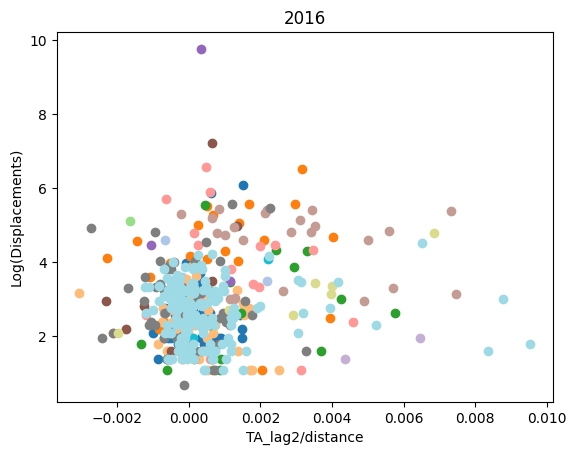

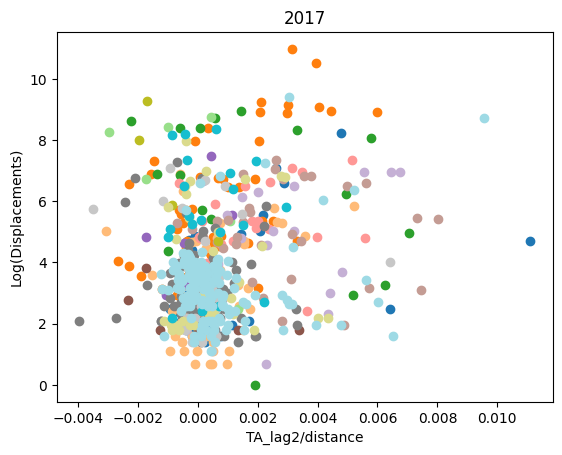

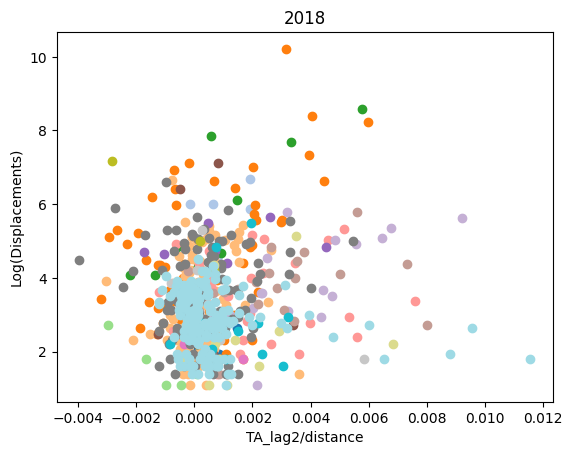

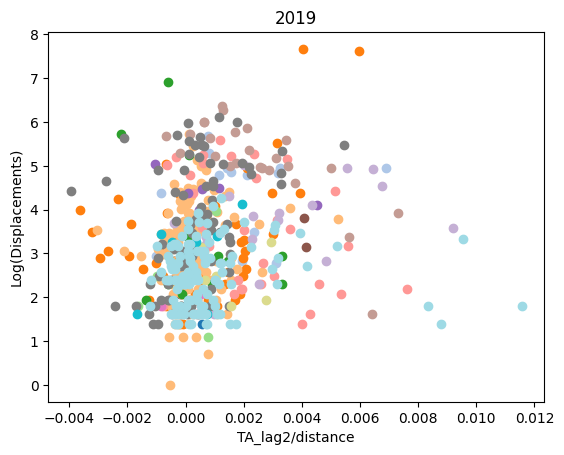

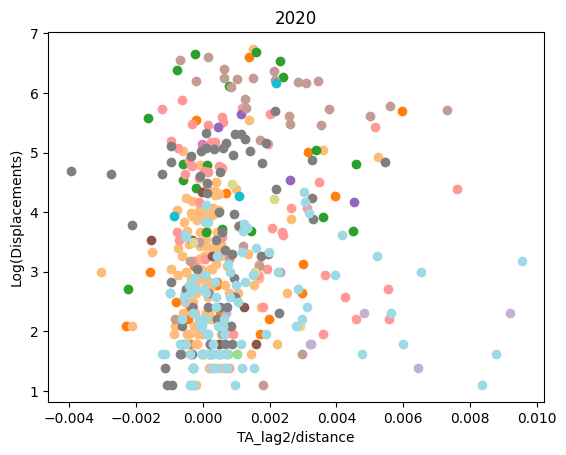

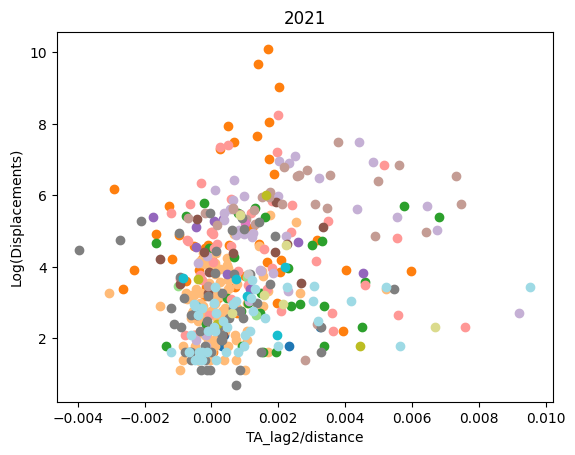

In [10]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

# add another loop for the other years and then plot them together
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for year in range(2016,2022):
    disp_matxs_i = disp_matxs[disp_matxs['year']==year]

    for j in regions:
        color = cmap(region_codes[regions == j][0])
        
        for month in range(1,13):
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == 2018) & (df_d['month'] == month)].reset_index()
                disp_reg['TA_lag2'] = df_m_y['TA_lag2']
                disp_reg = disp_reg[disp_reg[j]!=0]
                plt.scatter(disp_reg['inv_dist']*disp_reg['TA_lag2'], np.log(disp_reg[j]), color=color)    
                
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departure region')
    plt.xlabel('TA_lag2/distance')
    plt.ylabel('Log(Displacements)')
    plt.title(year)
    plt.show()  
       

/tmp/ipykernel_47738/2120210056.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


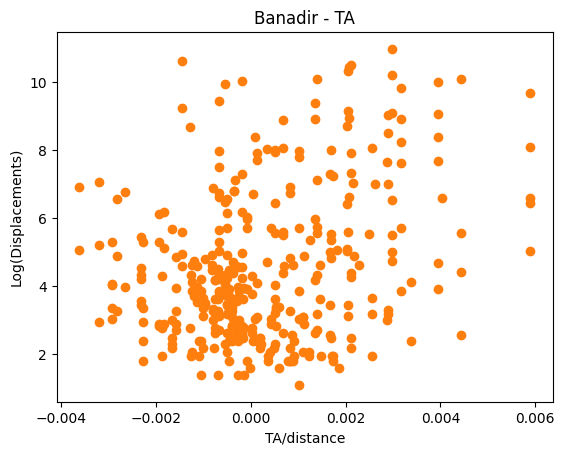

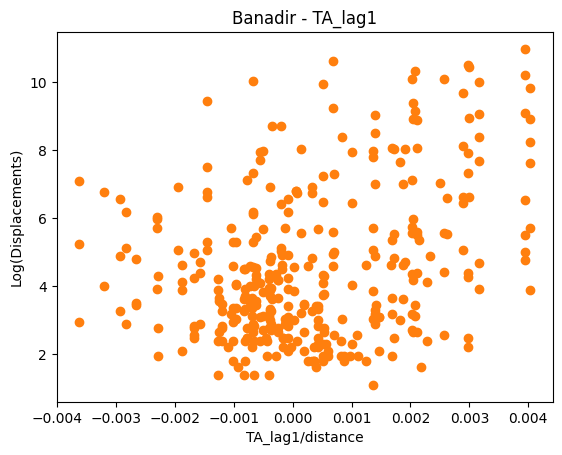

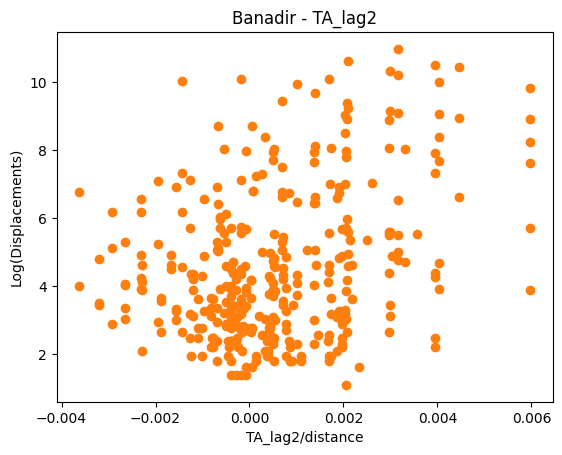

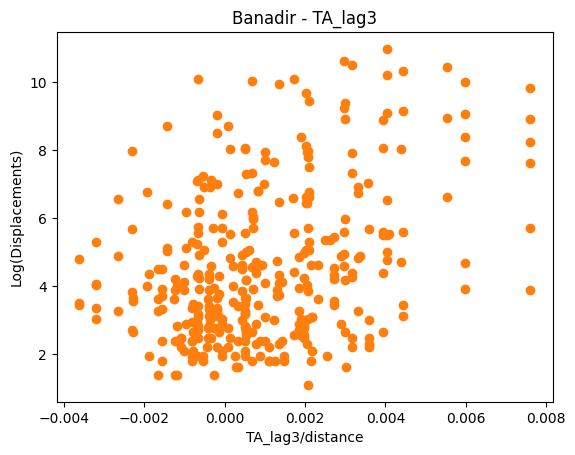

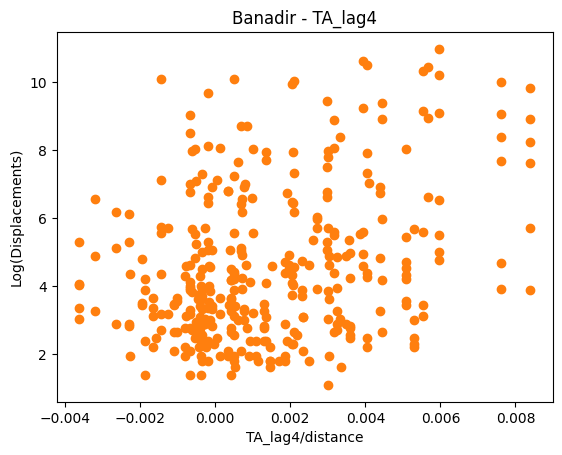

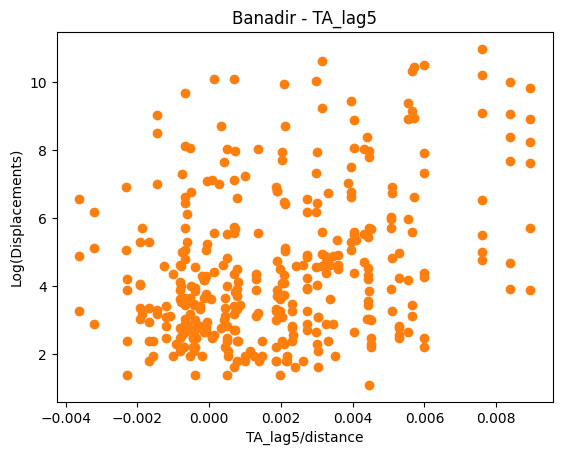

In [11]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

# add another loop for the other years and then plot them together
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for lag in vac_lag:
    for year in range(2016,2023):
        disp_matxs_i = disp_matxs[disp_matxs['year']==year]

        j = 'Banadir'
        color = cmap(region_codes[regions == j][0])
            
        for month in range(1,13):
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == 2018) & (df_d['month'] == month)].reset_index()
                disp_reg[lag] = df_m_y[lag]
                disp_reg = disp_reg[disp_reg[j]!=0]
                plt.scatter(disp_reg['inv_dist']*disp_reg[lag], np.log(disp_reg[j]), color=color)    
        plt.title('Banadir - ' + lag)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departure region')
        plt.xlabel(lag + '/distance')
        plt.ylabel('Log(Displacements)')

    plt.show()  

    #pearson
    #spearman

    #heatmp con regioni per righe e lag per colonne con il coeff di correlazione, per vedere se colonne sono piu significative
    #prova anche con PA e DL
    #diverse funz di distanza
    #per tutte le regioni distinte
    #e con tutte le regioni insieme
    #anzichè scatter heatmap dei punti (vedi seaborn, slack) 
    #(colora i punti proporzionalmente alla TA della regione di arrivo)
    #

/tmp/ipykernel_47738/3023112634.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


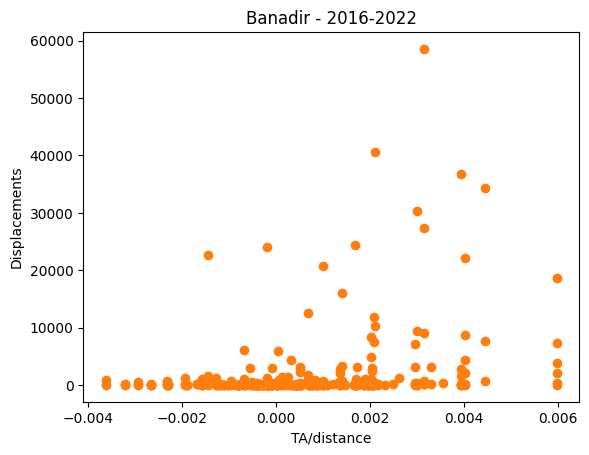

In [12]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

# add another loop for the other years and then plot them together
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for year in range(2016,2023):
    disp_matxs_i = disp_matxs[disp_matxs['year']==year]

    j = 'Banadir'
    color = cmap(region_codes[regions == j][0])
        
    for month in range(1,13):
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == 2018) & (df_d['month'] == month)].reset_index()
            disp_reg['TA_lag2'] = df_m_y['TA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            plt.scatter(disp_reg['inv_dist']*disp_reg['TA_lag2'], disp_reg[j], color=color)    
                
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departure region')
    plt.xlabel('TA/distance')
    plt.ylabel('Displacements')
plt.title('Banadir - 2016-2022')
plt.show() 

In [13]:
arrival = disp_data.groupby(['time','Current (Arrival) Region'])['Number of Individuals'].sum()
arrival

time        Current (Arrival) Region
2016-01-31  Awdal                        89
            Bakool                        0
            Banadir                       0
            Bari                         31
            Bay                         114
                                       ... 
2023-08-31  Nugaal                      500
            Sanaag                        0
            Sool                         54
            Togdheer                    266
            Woqooyi Galbeed              55
Name: Number of Individuals, Length: 1656, dtype: int64

/tmp/ipykernel_47738/1177775998.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


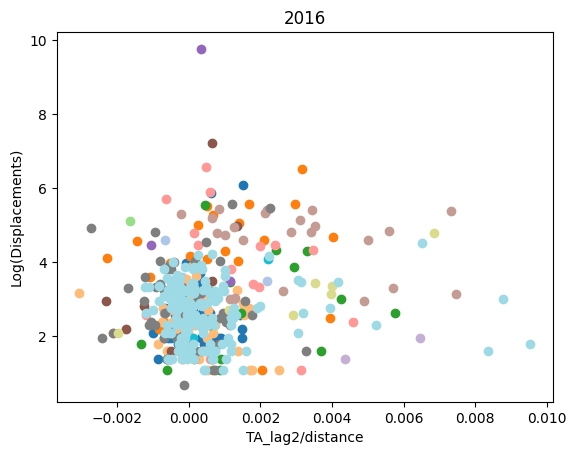

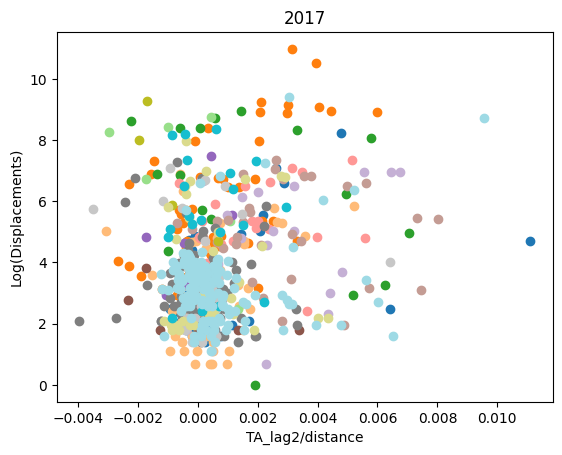

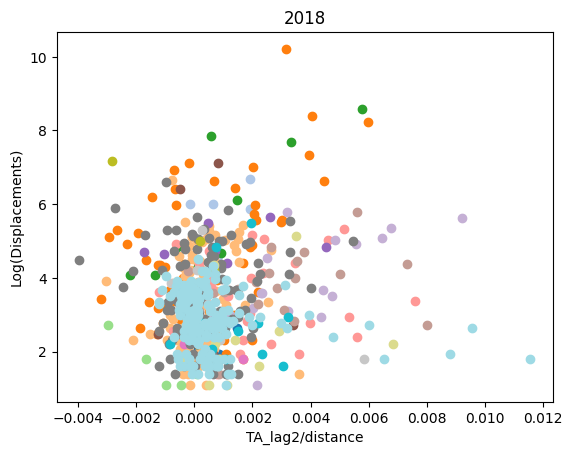

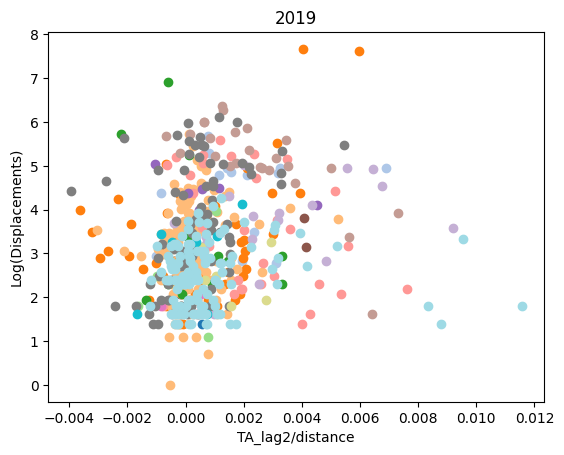

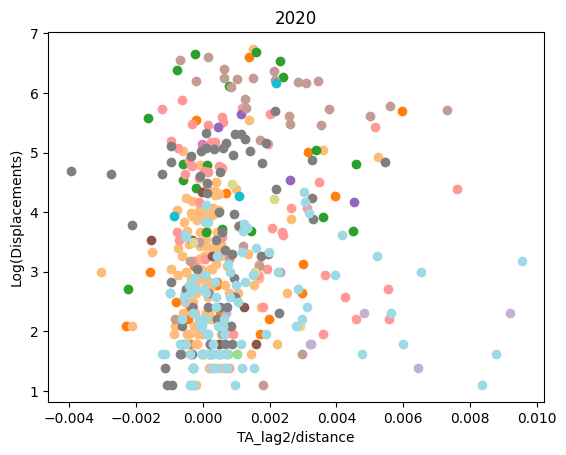

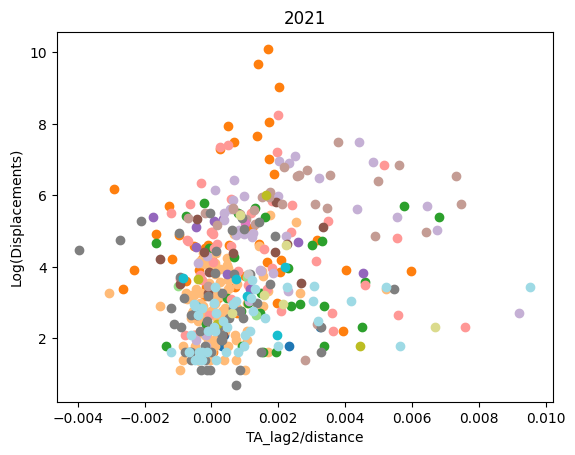

In [14]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

# add another loop for the other years and then plot them together
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for year in range(2016,2022):
    disp_matxs_i = disp_matxs[disp_matxs['year']==year]

    for j in regions:
        color = cmap(region_codes[regions == j][0])
        
        for month in range(1,13):
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == 2018) & (df_d['month'] == month)].reset_index()
                disp_reg['TA_lag2'] = df_m_y['TA_lag2']
                disp_reg = disp_reg[disp_reg[j]!=0]
                plt.scatter(disp_reg['inv_dist']*disp_reg['TA_lag2'], np.log(disp_reg[j]), color=color)    
                
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Departure region')
    plt.xlabel('TA_lag2/distance')
    plt.ylabel('Log(Displacements)')
    plt.title(year)
    plt.show()  